# <center>Лекція 4. Лінійні моделі класифікації і регресії
## <center>Частина 2

<a class="anchor" id="4-2"></a>

## Зміст 

- [4.3. Приклад регуляризації логістичної регресії](#4.3)
    + [4.3.1. Логістична регресія з поліноміальними ознаками](#4.3.1)
    + [4.3.2. Налаштування параметра регуляризації](#4.3.2)
- [4.4. Де логістична регресія працює добре, а де не дуже](#4.4)
    + [4.4.1. Аналіз відгуків IMDB до фільмів](#4.4.1)
    + [4.4.2. Простий підрахунок слів](#4.4.2)
    + [4.4.3. XOR-проблема](#4.4.3)
- [4.5. Криві валідації й навчання](#4.5)
    + [4.5.1. Як покращити модель?](#4.5.1)
    + [4.5.2. Скільки потрібно даних?](#4.5.2)

<a class="anchor" id="4.3"></a>

## <span style="color:blue; font-size:1.2em;">4.3. Приклад регуляризації логістичної регресії</span>

[Повернутися до змісту](#4-2)

У 1-ій частині лекції вже наводився приклад того, як поліноміальні ознаки дають змогу лінійним моделям будувати нелінійні розділяючі поверхні. Покажемо це на рисунках.

Подивимося, як регуляризація впливає на якість класифікації за набором даних щодо тестування мікрочіпів з [курсу Andrew Ng](https://www.coursera.org/learn/machine-learning) по машинному навчанню.

<a class="anchor" id="4.3.1"></a>

### <span style="color:blue; font-size:1.2em;">4.3.1. Логістична регресія з поліноміальними ознаками</span>

[Повернутися до змісту](#4-2)

Будемо використовувати логістичну регресію з поліноміальними ознаками і змінювати значення параметра регуляризації C. Спочатку подивимося, як регуляризація впливає на розділяючу границю класифікатора, інтуїтивно розпізнаємо перенавчання і недонавчання. Далі чисельно встановимо близький до оптимального параметр регуляризації за допомогою крос-валідації (`cross-validation`) і сіточного перебору (`GridSearch`).

In [1]:
from __future__ import division, print_function

# відключимо всякі попередження Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold

# підвищимо розмір графіків за замовчуванням
%config InlineBackend.figure_format = 'svg' 
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5

from drawdata import draw_scatter, draw_line, draw_histogram

Завантажуємо дані за допомогою методу `read_csv` бібліотеки` pandas`. У цьому наборі даних для 118 мікрочіпів (об'єкти) вказані результати двох тестів з контролю якості (дві числових ознаки) і вказано чи запустили мікрочіп у виробництво. Ознаки вже центровані, тобто від усіх значень віднято середні значення за стовпцями. Так, "середньому" мікрочіпу відповідають нульові значення результатів тестів.

In [2]:
# завантаження данних
data_microchip_tests = 'https://raw.githubusercontent.com/radiukpavlo/applied-math-packages/main/01_lecture-notes/amp_lecture-04_linear_models/microchip_tests.txt'

data = pd.read_csv(data_microchip_tests,
                   header=None, names = ('test1','test2','released'))

# інформація про набір даних
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   test1     118 non-null    float64
 1   test2     118 non-null    float64
 2   released  118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


Подивимося на перші й останні 5 рядків.

In [3]:
data.head(5)

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [4]:
data.tail(5)

,test1,test2,released
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0
117,0.632650,-0.030612,0


Збережемо навчальну вибірку й мітки цільового класу в окремих масивах `numpy`.

In [5]:
X = data.iloc[:,:2].values
y = data.iloc[:,2].values

Відобразимо дані. Червоний колір відповідає Defectiveим чіпам, зелений – нормальним.

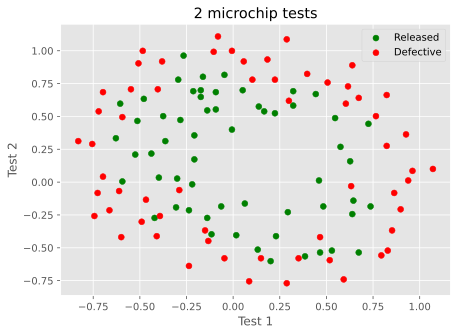

In [6]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Defective')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 microchip tests')
plt.legend();

Визначаємо функцію для відображення розділяючої кривої класифікатора

In [7]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))


    # кожній точці в сітці [x_min, m_max]x[y_min, y_max]
    # ставимо у відповідність свій колір
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

Поліноміальними ознаками до степеня $d$ для двох змінних $x_1$ і $x_2$ ми називаємо такі:

$$\large \{x_1^d, x_1^{d-1}x_2, \ldots x_2^d\} =  \{x_1^ix_2^j\}_{i+j=d, i,j \in \mathbb{N}}$$

Наприклад, для $d=3$ це будуть такі ознаки:

$$\large 1, x_1, x_2,  x_1^2, x_1x_2, x_2^2, x_1^3, x_1^2x_2, x_1x_2^2, x_2^3$$

Намалювавши трикутник Піфагора, ви зрозумієте, скільки таких ознак буде для $d=4,5...$ і взагалі для будь-якого $d$.
Простіше кажучи, таких ознак експоненціально багато, і будувати, скажімо, для 100 ознак поліноміальні степеня 10 може виявитися затратно (а більш того, і не потрібно).

Створимо об'єкт `sklearn`, який додасть до матриці $X$ поліноміальні ознаки аж до степеня 7.

In [8]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

In [9]:
X_poly.shape

(118, 36)

Навчимо логістичну регресію з параметром регуляризації $C = 10^{-2}$. Подамо розділяючу границю. Також перевіримо частку правильних відповідей класифікатора за навчальною вибіркою. Бачимо, що регуляризація виявилася занадто сильною, і модель "недонавчилась".

Частка правильних відповідей класифікатора за навчальною вибіркою: 0.627


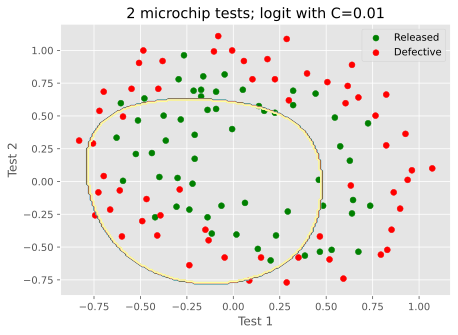

In [10]:
C = 1e-2
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Defective')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 microchip tests; logit with C=0.01')
plt.legend();

print("Частка правильних відповідей класифікатора за навчальною вибіркою:", 
      round(logit.score(X_poly, y), 3))

Збільшимо $C$ до 1. У такий спосіб ми *послаблюємо* регуляризацію. Тепер у рішенні значення ваг логістичної регресії можуть виявитися більшими (за модулем), ніж в попередньому випадку.

Частка правильних відповідей класифікатора за навчальною вибіркою: 0.831


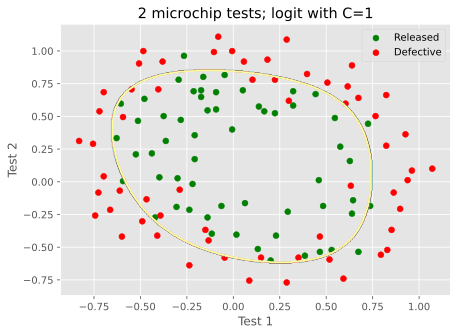

In [11]:
C = 1
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Defective')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 microchip tests; logit with C=1')
plt.legend();

print("Частка правильних відповідей класифікатора за навчальною вибіркою:", 
      round(logit.score(X_poly, y), 3))

Ще збільшимо $C$ – до 10 тисяч. Тепер регуляризації явно недостатньо, і ми спостерігаємо перенавчання. Можнемо помітити, що в попередньому випадку (за $C$ = 1 і "округлою" границею) частка правильних відповідей моделі за навчальною вибіркою не набагато нижча, ніж в третьому випадку, зате за новою вибіркою можемо припустити, що друга модель спрацює значно краще.

Частка правильних відповідей класифікатора за навчальною вибіркою: 0.873


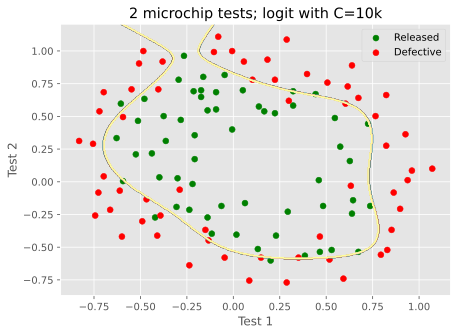

In [12]:
C = 1e4
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Defective')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 microchip tests; logit with C=10k')
plt.legend();

print("Частка правильних відповідей класифікатора за навчальною вибіркою:", 
      round(logit.score(X_poly, y), 3))

Щоб обговорити результати, перепишемо формулу для функціоналу, що оптимізується в логістичній регресії, в такому вигляді:

$$\large  J(X,y,w) = \mathcal{L} + \frac{1}{C}||w||^2,$$

де
 - $\mathcal{L}$ – логістична функція втрат, що просумована за всією вибіркою;
 - $C$ – обернений коефіцієнт регуляризації (тієї самої $C$ в `sklearn`-реалізації `LogisticRegression`)

**Проміжні висновки**:
 
 - чим більше значення параметру $C$, тим складніші залежності в даних може відновлювати модель (інтуїтивно $C$ відповідає "складності" моделі ([model capacity](https://en.wikipedia.org/wiki/Capacity_theory#Three_basic_components_of_the_capacity_model)));
 - якщо регуляризація занадто сильна (малі значення $C$), то розв'язком задачі мінімізації логістичної функції втрат може виявитися те, коли багато ваг обнулилися або стали занадто малим;  говорять також, що модель недостатньо "штрафується" за помилки (тобто у функціоналі $J$ "переважує" сума квадратів ваг, а помилка $\mathcal{L}$ може бути відносно великою); в такому випадку модель виявиться *недонавченою* (1 випадок);
 - навпаки, якщо регуляризація занадто слабка (великі значення $C$), то розв'язком задачі оптимізації може стати вектор $w$ з великими за модулем компонентами; в такому випадку більший внесок в оптимізуючий функціонал $J$ має $\mathcal{L}$ і, простіше кажучи, модель занадто "боїться" помилитися на об'єктах навчальної вибірки, тому отримаємо *перенавчання* (3 випадок);
 - то, яке значення $C$ вибрати, сама логістична регресія "не зрозуміє" (або ще кажуть "не вивчить"), тобто це не може бути визначено розв'язком оптимізаційної задачі, якою є логістична регресія (на відміну від ваг $w$ ); так само точно, дерево рішень не може "саме зрозуміти", яке обмеження на глибину вибрати (за один процес навчання); тому $C$ – це *гіперпараметр* моделі, який налаштовується під час крос-валідації, аналогічно до *max_depth* для дерева.

<a class="anchor" id="4.3.2"></a>

### <span style="color:blue; font-size:1.2em;">4.3.2. Налаштування параметра регуляризації</span>

[Повернутися до змісту](#4-2)

Тепер знайдемо оптимальне (в даному прикладі) значення параметра регуляризації $C$. Ми можемо це зробити допомогою `LogisticRegressionCV` – перебору параметрів по сітці з наступною крос-валідацією. Цей клас створений спеціально для логістичної регресії (для неї відомі ефективні алгоритми перебору параметрів), для довільної моделі ми б використовували `GridSearchCV`,` RandomizedSearchCV` або, наприклад, спеціальні алгоритми оптимізації гіперпараметров, що реалізовані в [hyperopt](http://hyperopt.github.io/hyperopt/).

In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_poly, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


LogisticRegressionCV(Cs=array([1.00000000e-02, 1.02334021e-02, 1.04722519e-02, 1.07166765e-02,
       1.09668060e-02, 1.12227736e-02, 1.14847155e-02, 1.17527712e-02,
       1.20270833e-02, 1.23077980e-02, 1.25950646e-02, 1.28890361e-02,
       1.31898690e-02, 1.34977233e-02, 1.38127630e-02, 1.41351558e-02,
       1.44650734e-02, 1.48026913e-02, 1.51481892e-02, 1.55017512e-02,
       1.58635653e-02, 1.62...
       6.45088409e+02, 6.60144909e+02, 6.75552832e+02, 6.91320378e+02,
       7.07455942e+02, 7.23968114e+02, 7.40865683e+02, 7.58157646e+02,
       7.75853206e+02, 7.93961785e+02, 8.12493021e+02, 8.31456781e+02,
       8.50863158e+02, 8.70722485e+02, 8.91045332e+02, 9.11842520e+02,
       9.33125118e+02, 9.54904456e+02, 9.77192128e+02, 1.00000000e+03]),
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     n_jobs=-1, verbose=1)

In [14]:
logit_searcher.C_

array([150.78450459])

Подивимося, як якість моделі (частка правильних відповідей за навчальною та валідаційною вибірками) змінюється у разі зміни гіперпараметра $C$.

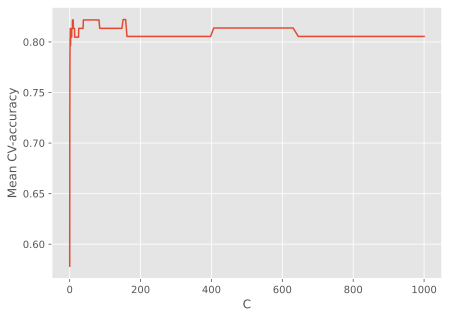

In [15]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');

Виділимо ділянку з "кращими" значеннями C.

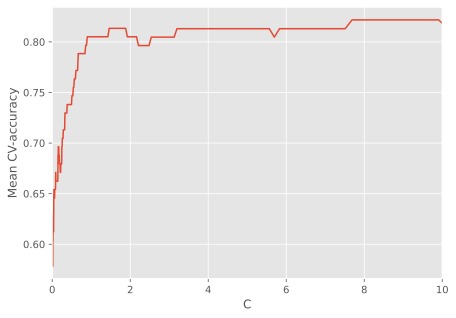

In [16]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');
plt.xlim((0,10));

Такі криві називаються *валідаційними*, і в `sklearn` для їхньої побудови є спеціальні методи.

<a class="anchor" id="4.4"></a>

## <span style="color:blue; font-size:1.2em;">4.4. Де логістична регресія працює добре, а де не дуже</span>

[Повернутися до змісту](#4-2)

<a class="anchor" id="4.4.1"></a>

### <span style="color:blue; font-size:1.2em;">4.4.1. Аналіз відгуків IMDB до фільмів</span>

[Повернутися до змісту](#4-2)

Будемо розв'язувати задачу бінарної класифікації відгуків IMDB до фільмів. Є навчальна вибірка з розміченими відгуками, щодо 12500 відгуків відомо, що вони хороші, ще про 12500 – що вони погані. Тут вже не так просто відразу розпочати з МН, тому що готової матриці чинників $X$ немає – її треба підготувати. Будемо використовувати найпростіший підхід – мішок слів ("Bag of words"). За такого підходу ознаками відгуку будуть індикатори наявності в ньому кожного слова з усього корпусу, де корпус – це множина всіх відгуків. Ідея ілюструється рисунком:

![img](https://raw.githubusercontent.com/radiukpavlo/applied-math-packages/main/03_img/4_2_10_bag_of_words.png)<br>

In [17]:
import os
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer

Завантажимо дані [звідси](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) (це пряме покликання на завантаження, а [тут](http://ai.stanford.edu/~amaas/data/sentiment/) опис набору даних). У навчальній і тестовій вибірках по 12500 тисяч хороших і поганих відгуків до фільмів.

In [18]:
from io import BytesIO
import requests
import tarfile

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

def load_imdb_dataset(extract_path="../../data", overwrite=False):
    #check if existed already
    if os.path.isfile(os.path.join(extract_path, "aclImdb", "README")) and not overwrite:
        print("IMDB dataset is already in place.")
        return

    print("Downloading the dataset from:  ", url)
    response = requests.get(url)

    tar = tarfile.open(mode= "r:gz", fileobj = BytesIO(response.content))

    data = tar.extractall(extract_path)

load_imdb_dataset()

IMDB dataset is already in place.


In [19]:
#change if you have it in alternative location
PATH_TO_IMDB = "../../data/aclImdb"

reviews_train = load_files(os.path.join(PATH_TO_IMDB, "train"),
                           categories=['pos', 'neg'])
text_train, y_train = reviews_train.data, reviews_train.target

reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"),
                          categories=['pos', 'neg'])
text_test, y_test = reviews_test.data, reviews_test.target

In [20]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in training data: 25000
[12500 12500]
Number of documents in test data: 25000
[12500 12500]


Приклади відгуку та відповідної мітки:

In [21]:
print(text_train[1])

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [22]:
y_train[1] # поганий відгук

0

In [23]:
text_train[2]

b'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!'

In [24]:
y_train[2] # хороший відгук

1

<a class="anchor" id="4.4.2"></a>

### <span style="color:blue; font-size:1.2em;">4.4.2. Простий підрахунок слів</span>

[Повернутися до змісту](#4-2)

Складемо словник усіх слів за допомогою CountVectorizer.

In [25]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

Подивимося на приклади отриманих "слів" (краще їх називати токенами). Бачимо, що багато важливих етапів оброблення тексту ми тут пропустили.

In [26]:
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
['pincher', 'pinchers', 'pinches', 'pinching', 'pinchot', 'pinciotti', 'pine', 'pineal', 'pineapple', 'pineapples', 'pines', 'pinet', 'pinetrees', 'pineyro', 'pinfall', 'pinfold', 'ping', 'pingo', 'pinhead', 'pinheads', 'pinho', 'pining', 'pinjar', 'pink', 'pinkerton', 'pinkett', 'pinkie', 'pinkins', 'pinkish', 'pinko', 'pinks', 'pinku', 'pinkus', 'pinky', 'pinnacle', 'pinnacles', 'pinned', 'pinning', 'pinnings', 'pinnochio', 'pinnocioesque', 'pino', 'pinocchio', 'pinochet', 'pinochets', 'pinoy', 'pinpoint', 'pinpoints', 'pins', 'pinsent']


Закодуємо пропозиції з текстів навчальної вибірки індексами вхідних слів. Використовуємо розріджений формат:

In [27]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

Подивимося, як перетворення подіяло на одну з пропозицій:

In [28]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [29]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
       66562])

In [30]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
        66562]))

Перетворимо так само тестову вибірку:

In [31]:
X_test = cv.transform(text_test)

Навчимо логістичну регресію:

In [32]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

CPU times: total: 62.5 ms
Wall time: 3.09 s


LogisticRegression(n_jobs=-1, random_state=7)

Подивимося на частки правильних відповідей за навчальною і тестовою вибірками:

In [33]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3),

(0.981, 0.864)

Коефіцієнти моделі можна гарно відобразити:

In [34]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    
    # отримуємо коефіцієнти з великими абсолютними значеннями
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    
    # відобразимо коефіцієнти
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [35]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();

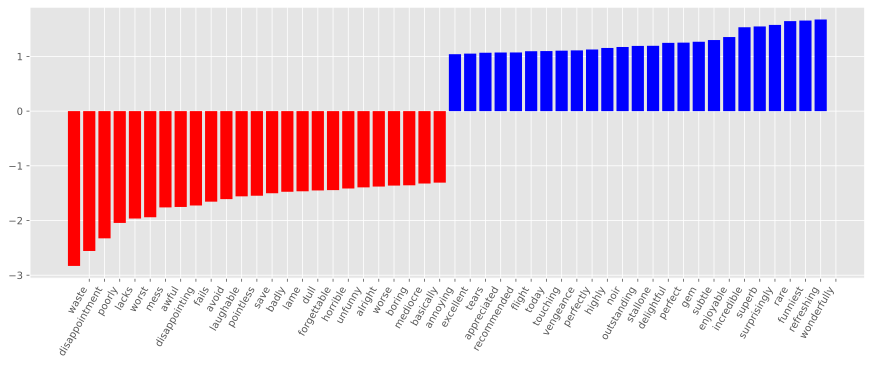

In [36]:
visualize_coefficients(logit, cv.get_feature_names())

Підберемо коефіцієнт регуляризації для логістичної регресії. Використовуємо `sklearn.pipeline`, оскільки` CountVectorizer` правильно застосовувати тільки за тими даними, за якими в поточний момент навчається модель (щоб не "підглядати" в тестову вибірку і не брати до уваги по ній частоти входження слів). В даному випадку `pipeline` задає послідовність дій: застосувати` CountVectorizer`, потім навчити логістичну регресію.

In [37]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(), 
                                LogisticRegression(n_jobs=-1, random_state=7))

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

0.86408
CPU times: total: 11.4 s
Wall time: 14.5 s


In [38]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1, return_train_score=True)

grid_logit.fit(text_train, y_train)

CPU times: total: 8.81 s
Wall time: 41.2 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=7))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
             return_train_score=True)

Краще значення C і відповідна якість на крос-валідації:

In [39]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.1}, 0.8850799148356624)

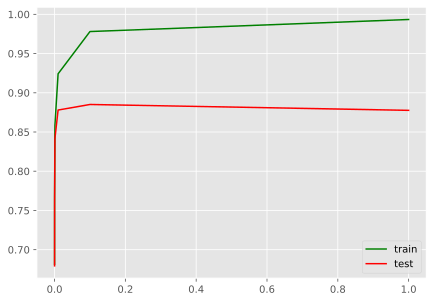

In [40]:
plot_grid_scores(grid_logit, 'logisticregression__C')

За валідаційною вибіркою:

In [41]:
grid_logit.score(text_test, y_test)

0.87812

Тепер те ж саме, але з випадковим лісом:

In [42]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)

In [43]:
%%time
forest.fit(X_train, y_train)

CPU times: total: 3min 58s
Wall time: 16.8 s


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)

In [44]:
round(forest.score(X_test, y_test), 3)

0.855

Відповідно результатів вище бачимо, що з використанням логістичної регресії ми досягли більшої частки правильних відповідей з меншими зусиллями (0.855 < 0.879).

<a class="anchor" id="4.4.3"></a>

### <span style="color:blue; font-size:1.2em;">4.4.3. XOR-проблема</span>

[Повернутися до змісту](#4-2)

Тепер розглянемо приклад, де лінійні моделі справляються гірше.

Лінійні методи класифікації будують все ж дуже просту розділяючу поверхню – гіперплощину. Найвідоміший іграшковий приклад, в якому класи можна без помилок розділити гіперплощиною (тобто прямою, якщо це 2D), отримав назву "the XOR problem". XOR – це "виключне АБО", булева функція з такою таблицею істинності:

![img](https://raw.githubusercontent.com/radiukpavlo/applied-math-packages/main/03_img/4_2_11_XOR_table.gif)<br>

XOR дав назву простій задачі бінарної класифікації, в якій класи подано множинами точок, що перетинаються і є витягнутими за діагоналями.

In [45]:
# створюємо дані
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

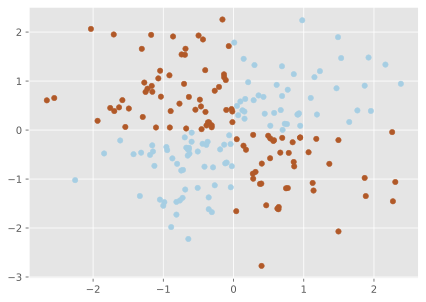

In [46]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired);

Очевидно, не можна провести пряму так, щоб без помилок відокремити один клас від іншого. Тому логістична регресія погано справляється з такою задачею.

In [47]:
def plot_boundary(clf, X, y, plot_title):
    
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
    clf.fit(X, y)
    
    # відобразимо функцію рішення для кожної точки на координатній площині
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

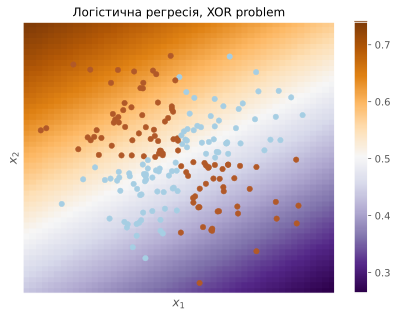

In [48]:
plot_boundary(LogisticRegression(), X, y,
              "Логістична регресія, XOR problem")

А ось якщо на вхід подати поліноміальні ознаки, в даному випадку до степеня 2, то задача розв'язується.

In [49]:
from sklearn.pipeline import Pipeline

logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logit', LogisticRegression())])

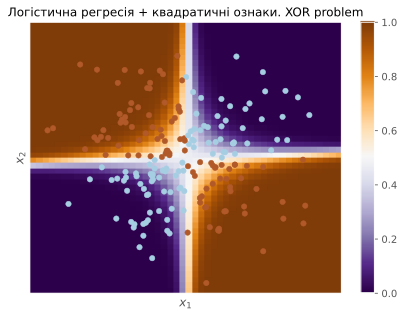

In [50]:
plot_boundary(logit_pipe, X, y,
              "Логістична регресія + квадратичні ознаки. XOR problem")

Тут логістична регресія все одно будувала гіперплощину, але в 6-вимірному просторі ознак $1, x_1, x_2, x_1^2, x_1x_2$ и $x_2^2$. У проекції на початковий простір ознак $x_1, x_2$ границю вийшла нелінійна.

На практиці поліноміальні ознаки дійсно допомагають, але будувати їх явно – обчислювально неефективно. Набагато швидше працює метод опорних векторів з ядровим трюком. За такого підходу в просторі високої розмірності обраховується тільки відстань між об'єктами (що задається функцією-ядром), а явно створювати комбінаторно велику кількість ознак не потрібно. З цим питанням можна детальніше ознайомитися в курсі Євгенія Соколова – [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem10_linear.pdf) (математика вже серйозна).

<a class="anchor" id="4.5"></a>

## <span style="color:blue; font-size:1.2em;">4.5. Криві валідації й навчання</span>

[Повернутися до змісту](#4-2)

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import validation_curve

<a class="anchor" id="4.5.1"></a>

### <span style="color:blue; font-size:1.2em;">4.5.1. Як покращити модель?</span>

[Повернутися до змісту](#4-2)

Ми вже маємо уявлення щодо перевірки моделі, крос-валідації та регуляризації.
Тепер розглянемо головне питання:

**Якщо якість моделі нас не влаштовує, то що робити?**

- Зробити модель складнішою чи, навпаки, спростити?
- Додати більше ознак?
- Чи потрібно додати більше даних для навчання?

Відповіді на ці питання не завжди лежать на поверхні. Зокрема, іноді використання більш складної моделі призведе до погіршення показників. Або додавання спостережень не призведе до відчутних змін. Здатність прийняти правильне рішення й вибрати правильний спосіб поліпшення моделі, власне кажучи, і відрізняє хорошого фахівця від поганого.

Будемо працювати з уже знайомими даними щодо відтоку клієнтів телеком-оператора:

In [52]:
telecom_churn_url = 'https://raw.githubusercontent.com/radiukpavlo/applied-math-packages/main/01_lecture-notes/amp_lecture-04_linear_models/telecom_churn.csv'

In [53]:
data_telchurn = pd.read_csv(telecom_churn_url).drop('State', axis=1)

data_telchurn['International plan'] = data_telchurn['International plan'].map({'Yes': 1, 'No': 0})
data_telchurn['Voice mail plan'] = data_telchurn['Voice mail plan'].map({'Yes': 1, 'No': 0})

y_telchurn = data_telchurn['Churn'].astype('int').values
X_telchurn = data_telchurn.drop('Churn', axis=1).values

Тут будемо навчати логістичну регресію за допомогою стохастичного градієнтного спуску. Наразі так швидше. Але в подальшому стохастичному градієнтному спуску буде присвячена окрема тема. 

In [54]:
alphas = np.logspace(-2, 0, 20)
sgd_logit = SGDClassifier(loss='log', n_jobs=-1, random_state=17, max_iter=5)
logit_pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=2)),
                       ('sgd_logit', sgd_logit)])
val_train, val_test = validation_curve(logit_pipe, X_telchurn, y_telchurn,
                                       param_name='sgd_logit__alpha', param_range=alphas, cv=5,
                                       scoring='roc_auc')

Побудуємо валідаційні криві, що показують, як якість (ROC AUC) за навчальною та валідаційною вибірками змінюється зі зміною параметра регуляризації.

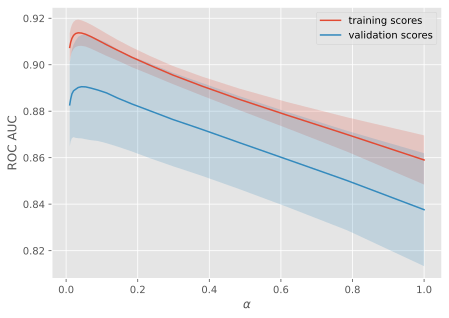

In [55]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel(r'$\alpha$'); plt.ylabel('ROC AUC')
plt.legend();

Тенденцію видно відразу, і вона дуже часто зустрічається.

1. Для простих моделей навчальна та валідаційна помилка перебувають приблизно поруч, і вони великі. Це говорить про те, що модель *недонавчилась*: тобто вона не має достатню кількість параметрів.

2. Для сильно ускладнених моделей навчальна та валідаційна помилки значно відрізняються. Це можна пояснити *перенавчанням*: коли параметрів занадто багато або не вистачає регуляризації, алгоритм може "відволікатися" на шум в даних й не враховувати упускати основний тренд.

<a class="anchor" id="4.5.2"></a>

### <span style="color:blue; font-size:1.2em;">4.5.2. Скільки потрібно даних?</span>

[Повернутися до змісту](#4-2)

Відомо, що чим більше даних використовує модель, тим краще. Але як нам зрозуміти в конкретній ситуації, чи допоможуть нові дані? Скажімо, чи доцільно нам витратити \$ N на роботу асесорів, щоб збільшити вибірку вдвічі?

Оскільки нових даних поки може і не бути, розумно змінювати розмір наявної навчальної вибірки та дивитися, як якість розв'язку задачі залежить від обсягу даних, за якими ми навчали модель. У такий спосіб отримують *криві навчання* (*learning curves*).

Ідея проста: ми відображаємо помилку, як функцію від кількості прикладів, що використовуються для навчання. Водночас параметри моделі фіксуються заздалегідь.

In [56]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(degree=2, alpha=0.01):
    train_sizes = np.linspace(0.05, 1, 20)
    logit_pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=degree)), 
                           ('sgd_logit', SGDClassifier(n_jobs=-1, random_state=17, alpha=alpha))])
    N_train, val_train, val_test = learning_curve(logit_pipe,
                                                  X, y, train_sizes=train_sizes, cv=5,
                                                  scoring='roc_auc')
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('AUC')
    plt.legend()

Давайте глянемо, що ми отримаємо для лінійної моделі. Коефіцієнт регуляризації поставимо великим.

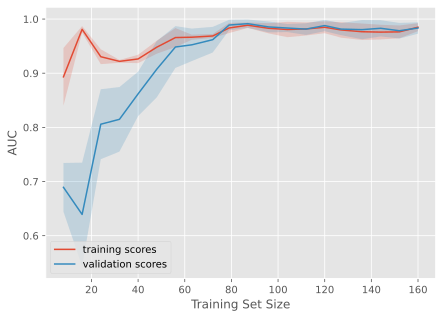

In [57]:
plot_learning_curve(degree=2, alpha=10)

Типова ситуація: для невеликого обсягу даних помилки за навчальною вибіркою й в процесі крос-валідації досить сильно відрізняються, що вказує на перенавчання. Для тієї ж моделі, але з великим об'ємом даних помилки "збігаються", що вказує на недонавчання.

Якщо додати ще дані, то помилка за навчальною вибіркою не буде рости, але з іншого боку, помилка за тестовими даними не буде зменшуватися.

Виходить, що помилки "зійшлися", і додавання нових даних не допоможе. Зокрема цей випадок – найцікавіший з точки зору бізнесу. Можлива ситуація, коли ми збільшуємо вибірку в 10 разів. Але якщо не міняти складність моделі, це може і не допомогти. Тобто стратегія "налаштував один раз м далі використовую 10 раз" може і не працювати.

Що буде, якщо змінити коефіцієнт регуляризації?
Бачимо хорошу тенденцію – криві поступово збігаються, і якщо далі рухатися вправо (додавати в модель дані), можна ще підвищити якість за валідаційними даними.

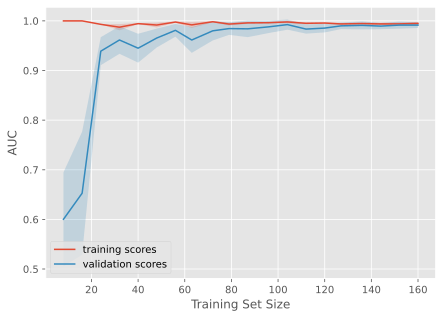

In [58]:
plot_learning_curve(degree=2, alpha=0.05)

А якщо ускладнити ще більше?

Проявляється перенавчання – AUC падає як під час навчання, так і під час валідації.

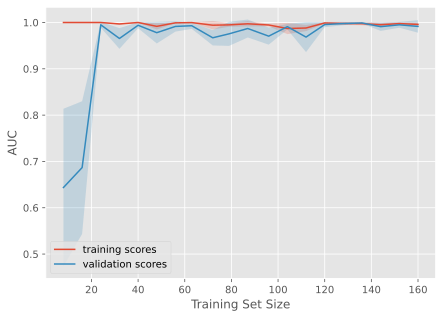

In [59]:
plot_learning_curve(degree=2, alpha=1e-4)

Будуючи подібні криві, можна зрозуміти, куди рухатися, і як правильно налаштувати складність моделі за новими даними.

## Висновки

1. Помилка за навчальною вибіркою сама по собі нічого не говорить щодо якості моделі.
2. Крос-валідаційна помилка показує, наскільки добре модель підлаштовується під дані (наявний тренд в даних), зберігаючи при цьому здатність узагальнення за новими даними.
3. *Валідаційна крива* – це графік, який показує результат за навчальною та валідаційною вибірками залежно від *складності моделі*:
   - якщо дві криві розташовуються близько одна до дної, а обидві помилки великі – це ознака *недонавчання*;
   - Якщо дві криві далеко одна від одної – це індикатор *перенавчання*.
4. *Крива навчання* – це графік, який показує результати за навчальною та валідаційною вибірками залежно від кількості спостережень:
   - якщо криві збіглися одна до одної, додавання нових даних не допоможе – треба міняти складність моделі;
   - якщо криві не зійшлися, додавання нових даних може поліпшити результат.